In [41]:
# %python3 -m pip install -r requirements.txt
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

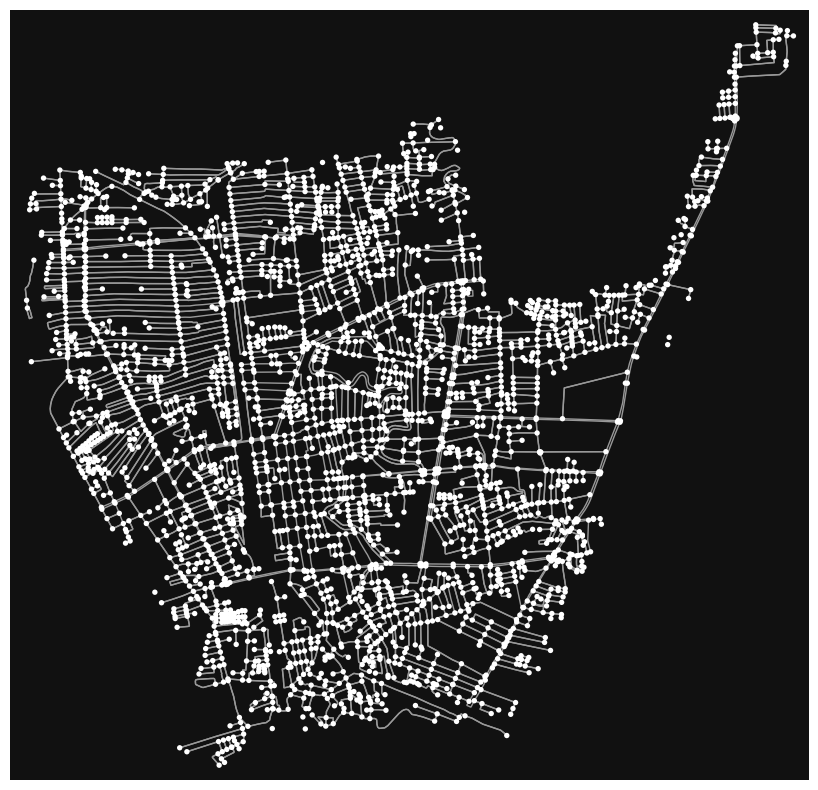

In [42]:
place_name = "Hat Yai District, Songkhla, Thailand"
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

# Build full graph from place
graph = load_graph()

# Polygon filter
area_coordinates = [
    (100.502769, 7.037112),
    (100.506839, 7.036403),
    (100.484659, 6.981756),
    (100.483150, 6.987053),
    (100.467264, 6.986236),
    (100.466289, 6.983138),
    (100.461562, 6.984726),
    (100.460087, 6.997991),
    (100.451423, 7.006697),
    (100.450599, 7.022179),
    (100.452207, 7.026726),
    (100.477673, 7.027629),
    (100.478553, 7.030400),
    (100.481593, 7.031277),
    (100.484508, 7.017035),
    (100.496636, 7.018713),
]
polygon = Polygon(area_coordinates)

# Clip graph to polygon
graph_filtered = ox.truncate.truncate_graph_polygon(graph, polygon)

# Plot
fig, ax = ox.plot_graph(graph_filtered, figsize=(12, 10))

In [43]:
edges = ox.graph_to_gdfs(graph_filtered, nodes=False, edges=True)

In [44]:
edges.columns

Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel'],
      dtype='object')

In [45]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_filtered)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])
# Export nodes and edges to CSV files
nodes_csv = nodes.copy()
# Convert geometry to separate lat/lon columns for CSV export
nodes_csv['longitude'] = nodes_csv.geometry.x
nodes_csv['latitude'] = nodes_csv.geometry.y
nodes_csv = nodes_csv.drop('geometry', axis=1)

edges_csv = edges.copy()
# Drop geometry column for CSV export as it's complex
edges_csv = edges_csv.drop('geometry', axis=1)

# Export to CSV
nodes_csv.to_csv('data/raw/road/hatyai_nodes.csv', index=True)
edges_csv.to_csv('data/raw/road/hatyai_edges.csv', index=True)

print(f"\nExported data:")
print(f"Nodes exported to 'hatyai_nodes.csv' ({len(nodes_csv)} records)")
print(f"Edges exported to 'hatyai_edges.csv' ({len(edges_csv)} records)")


Network Statistics:
Number of nodes: 3029
Number of edges: 6999

Nodes columns: ['y', 'x', 'highway', 'street_count', 'junction', 'geometry']

Edges columns: ['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'lanes', 'maxspeed', 'ref', 'junction', 'access', 'tunnel']

Network bounds (lon_min, lat_min, lon_max, lat_max): [100.4511039   6.9839845 100.5063432   7.0369187]
u            v            key
485580824    8642774010   0       48.863447
             4900465156   0       52.419118
             12008685153  0      269.444197
             13368519214  0       94.990321
485580829    3307271116   0        7.747836
                                    ...    
13434451561  13434451561  1      292.894345
13437630804  2506092381   0        1.884666
                          1        1.884666
             2506092132   0       43.923334
             2506092371   0       88.701742
Name: length, Length: 6999, dtype: float64

Exported data:
Nodes exported to 'hat

In [46]:
nodes = pd.read_csv('data/raw/road/hatyai_nodes.csv')
edges = pd.read_csv('data/raw/road/hatyai_edges.csv')

In [47]:
# Randomly allocate population/households across nodes
pop_male = 64864
pop_female = 75987
pop_total = 140851
households = 70703

rng = np.random.default_rng(888)
n = len(nodes)
weights = np.ones(n) / n

nodes["pop_male"] = rng.multinomial(pop_male, weights)
nodes["pop_female"] = rng.multinomial(pop_female, weights)
nodes["pop_total"] = nodes["pop_male"] + nodes["pop_female"]
nodes["households"] = rng.multinomial(households, weights)

print("Population assigned:"
      f" male={nodes['pop_male'].sum()}"
      f" female={nodes['pop_female'].sum()}"
      f" total={nodes['pop_total'].sum()}"
      f" households={nodes['households'].sum()}")

nodes.to_csv("data/clean/hatyai_nodes_with_pop.csv", index=False)
print("Saved with population -> data/clean/hatyai_nodes_with_pop.csv")

Population assigned: male=64864 female=75987 total=140851 households=70703
Saved with population -> data/clean/hatyai_nodes_with_pop.csv


In [49]:
# Load flood grid data (lon=x, lat=y)
flood = pd.read_csv("filtered_locations_inside.csv")


# Build GeoDataFrames for nearest-neighbor join
flood_gdf = gpd.GeoDataFrame(
    flood,
    geometry=gpd.points_from_xy(flood.x, flood.y),
    crs="EPSG:4326",
)
nodes_gdf = gpd.GeoDataFrame(
    nodes.copy(),
    geometry=gpd.points_from_xy(nodes.x, nodes.y),
    crs="EPSG:4326",
)

# Attach nearest flood gridcode to each node
nodes_nearest = gpd.sjoin_nearest(
    nodes_gdf,
    flood_gdf[["gridcode", "geometry"]],
    how="left",
    distance_col="flood_distance_deg",
)
nodes_nearest["flood_level"] = nodes_nearest["gridcode"]
nodes_with_flood = nodes_nearest.drop(columns=["index_right"])

# Propagate flood level to edges using the max of endpoint levels
node_flood = (
    nodes_with_flood.groupby("osmid")["flood_level"]
    .max()
)
edges_with_flood = edges.copy()
edges_with_flood["flood_level_u"] = edges_with_flood["u"].map(node_flood)
edges_with_flood["flood_level_v"] = edges_with_flood["v"].map(node_flood)
edges_with_flood["flood_level"] = edges_with_flood[["flood_level_u", "flood_level_v"]].max(axis=1)

# Save results
nodes_with_flood.drop(columns=["geometry"]).to_csv("data/clean/hatyai_nodes_flood.csv", index=False)
edges_with_flood.to_csv("data/clean/hatyai_edges_flood.csv", index=False)

print("Flood attributes attached:")
print(nodes_with_flood[["osmid", "flood_level"]].head())
print(edges_with_flood[["u", "v", "flood_level"]].head())

Flood attributes attached:
       osmid  flood_level
0  485580824            1
0  485580824            1
1  485580829            4
2  485580840            5
3  485580841            5
           u            v  flood_level
0  485580824   8642774010            1
1  485580824   4900465156            2
2  485580824  12008685153            1
3  485580824  13368519214            1
4  485580829   3307271116            4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
